In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ipywidgets import interact, IntSlider

## dsDRYAD

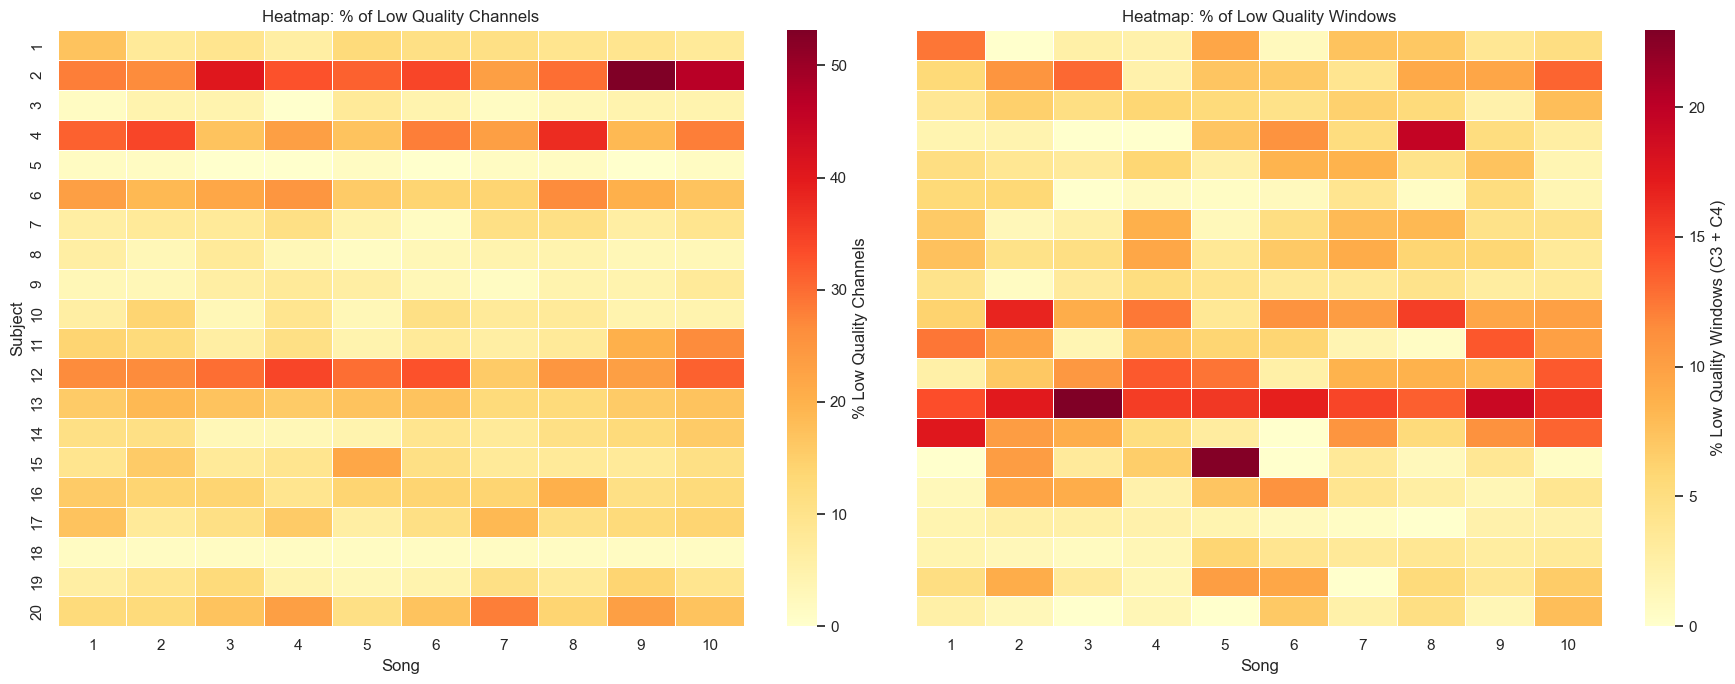

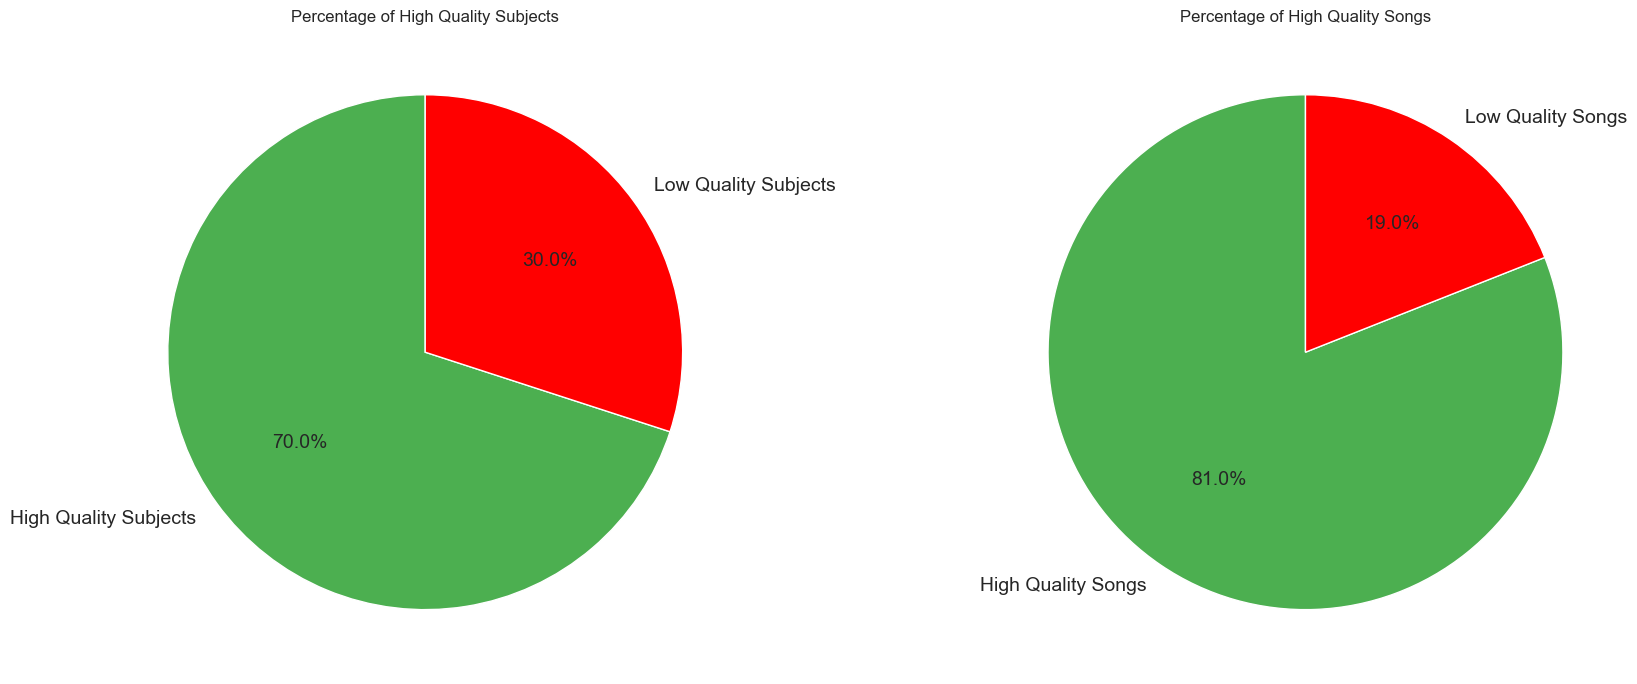

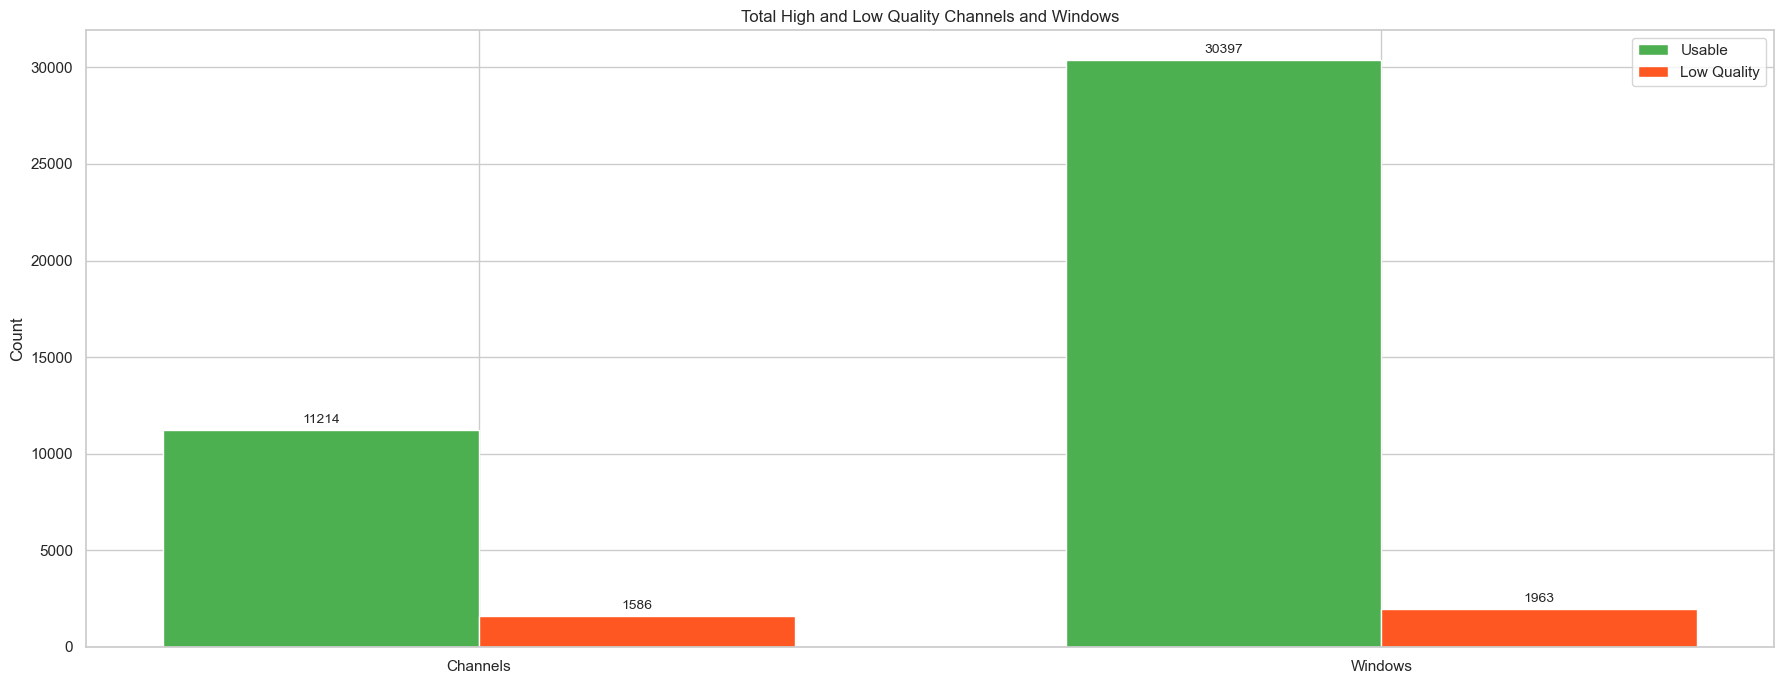

In [ ]:
# Load data
data = scipy.io.loadmat('dsDRYAD_quality_data.mat', squeeze_me=True, struct_as_record=False)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

quality_data = data['quality_data']
n_subjects = len(quality_data)
max_songs = 10

# Initialize variables
usable_songs_per_subject, percent_bad_channels_per_song, songs_per_subject = [], [], []
bad_channels_by_criterion = {k: [] for k in ['c1', 'c2', 'c3', 'c4']}
bad_windows_by_criterion = {k: [] for k in ['c3', 'c4']}
song_level_data = []

# Process data
for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    songs_per_subject.append(len(subj_songs))
    usable_count = 0

    for song in subj_songs:
        total_ch = song.total_channels
        bad_ch = {k: len(np.atleast_1d(getattr(song, f"{k}_bad_channels", []))) for k in bad_channels_by_criterion}
        for k, v in bad_ch.items(): bad_channels_by_criterion[k].append(v)

        for k in bad_windows_by_criterion:
            bad_windows_by_criterion[k].append(len(np.atleast_1d(getattr(song, f"{k}_bad_windows", []))))

        all_bad = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        percent_bad = 100 * len(all_bad) / total_ch
        percent_bad_channels_per_song.append(percent_bad)

        if percent_bad <= 20: usable_count += 1

        song_level_data.append({
            'subject': subj.subject_id,
            'song': song.song_id,
            'percent_bad': percent_bad,
            **bad_ch
        })

    usable_songs_per_subject.append(usable_count)

df_song = pd.DataFrame(song_level_data)

# ----- Heatmaps -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Heatmap over channels
heatmap_channels = np.full((n_subjects, max_songs), np.nan)
for r in df_song.itertuples():
    heatmap_channels[int(r.subject)-1, int(r.song)-1] = r.percent_bad

sns.heatmap(heatmap_channels, cmap='YlOrRd', ax=axes[0], cbar_kws={'label': '% Low Quality Channels'}, linewidths=0.5)
axes[0].set(title="Heatmap: % of Low Quality Channels", xlabel="Song", ylabel="Subject")
axes[0].set_xticks(np.arange(max_songs) + 0.5)
axes[0].set_yticks(np.arange(n_subjects) + 0.5)
axes[0].set_xticklabels(np.arange(1, max_songs + 1))
axes[0].set_yticklabels(np.arange(1, n_subjects + 1))

# Heatmap over windows
heatmap_windows = np.full((n_subjects, max_songs), np.nan)
for subj in quality_data:
    subj_id = int(subj.subject_id)
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    for song in subj_songs:
        song_id = int(song.song_id)
        total_windows = song.total_windows
        c3_bad = len(np.atleast_1d(getattr(song, 'c3_bad_windows', [])))
        c4_bad = len(np.atleast_1d(getattr(song, 'c4_bad_windows', [])))
        heatmap_windows[subj_id-1, song_id-1] = 100 * (c3_bad + c4_bad) / total_windows if total_windows else np.nan

sns.heatmap(heatmap_windows, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '% Low Quality Windows (C3 + C4)'}, linewidths=0.5)
axes[1].set(title="Heatmap: % of Low Quality Windows", xlabel="Song")
axes[1].set_xticks(np.arange(max_songs) + 0.5)
axes[1].set_yticks(np.arange(n_subjects) + 0.5)
axes[1].set_xticklabels(np.arange(1, max_songs + 1))
axes[1].set_yticklabels(np.arange(1, n_subjects + 1))

plt.tight_layout()
plt.savefig('dsDRYAD_heatmaps.png', dpi=200)
plt.show()

# ----- Pie Charts -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = ['#4CAF50', "#FF0000"]

# Subject and song quality
usable_subjects = sum(np.array(usable_songs_per_subject) > np.ceil(0.8 * max_songs))
subject_sizes = [100 * usable_subjects / n_subjects, 100 - 100 * usable_subjects / n_subjects]
song_sizes = [
    100 * sum(usable_songs_per_subject) / sum(songs_per_subject),
    100 - 100 * sum(usable_songs_per_subject) / sum(songs_per_subject)
]

axes[0].pie(subject_sizes, labels=['High Quality Subjects', 'Low Quality Subjects'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[0].set_title('Percentage of High Quality Subjects')

axes[1].pie(song_sizes, labels=['High Quality Songs', 'Low Quality Songs'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[1].set_title('Percentage of High Quality Songs')

plt.tight_layout()
plt.savefig('dsDRYAD_pie.png', dpi=200)
plt.show()

# ----- Bar Charts -----
usable_channels_all = usable_windows_all = total_channels_all = total_windows_all = 0

for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, (list, np.ndarray)) else [subj.songs]
    for song in subj_songs:
        # Channels
        total_channels = song.total_channels
        bad_channels = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        total_channels_all += total_channels
        usable_channels_all += total_channels - len(bad_channels)

        # Windows
        total_windows = song.total_windows
        bad_windows = sum(len(np.atleast_1d(getattr(song, f"c{i}_bad_windows", []))) for i in [3, 4])
        total_windows_all += total_windows
        usable_windows_all += total_windows - bad_windows

# Bar
labels = ['Channels', 'Windows']
usable = [usable_channels_all, usable_windows_all]
non_usable = [total_channels_all - usable_channels_all, total_windows_all - usable_windows_all]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 7))
bars1 = ax.bar(x - width/2, usable, width, label='Usable', color='#4CAF50')
bars2 = ax.bar(x + width/2, non_usable, width, label='Low Quality', color='#FF5722')

ax.set_ylabel('Count')
ax.set_title('Total High and Low Quality Channels and Windows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('dsDRYAD_bar.png', dpi=200)
plt.show()


## dsMUSING

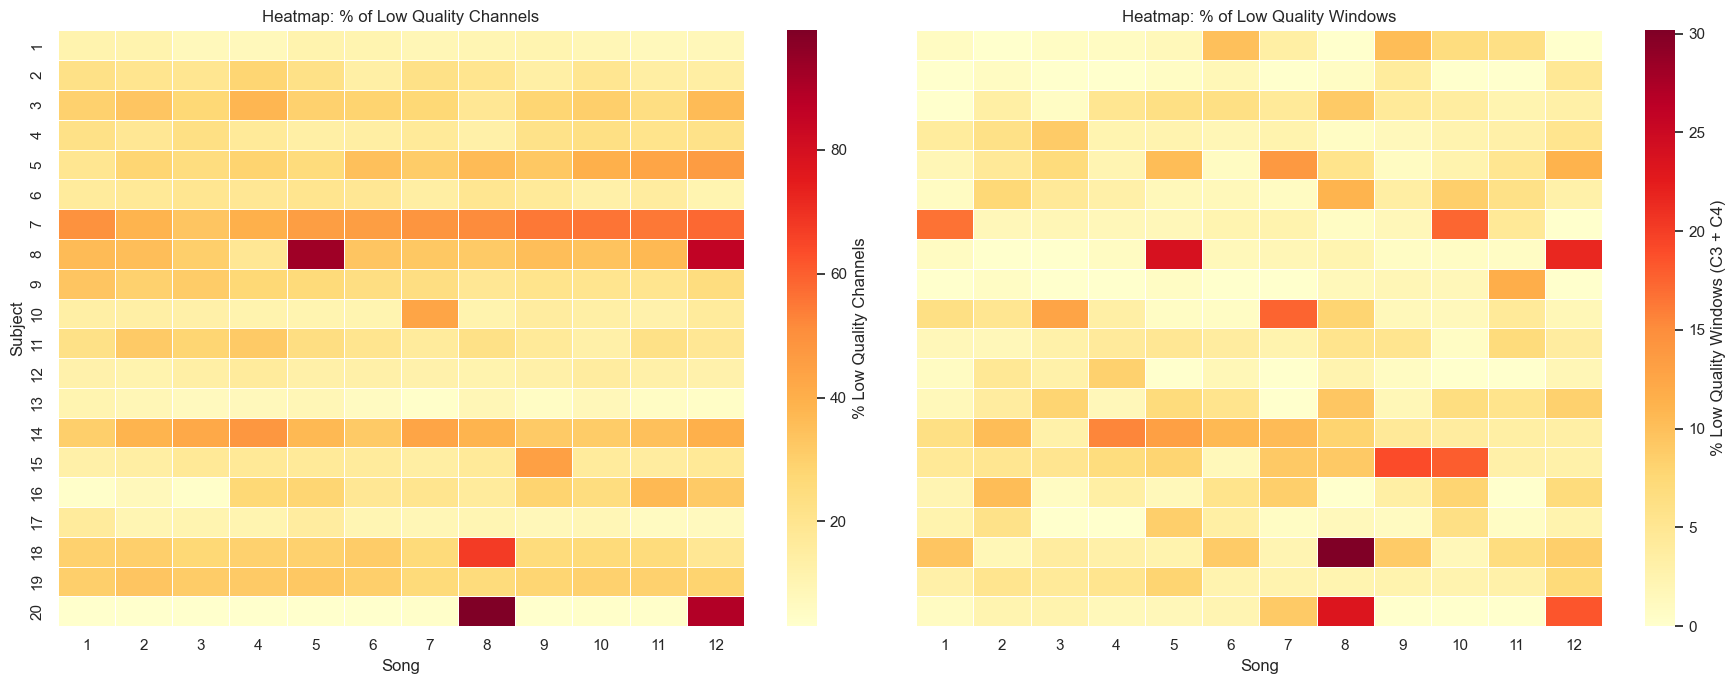

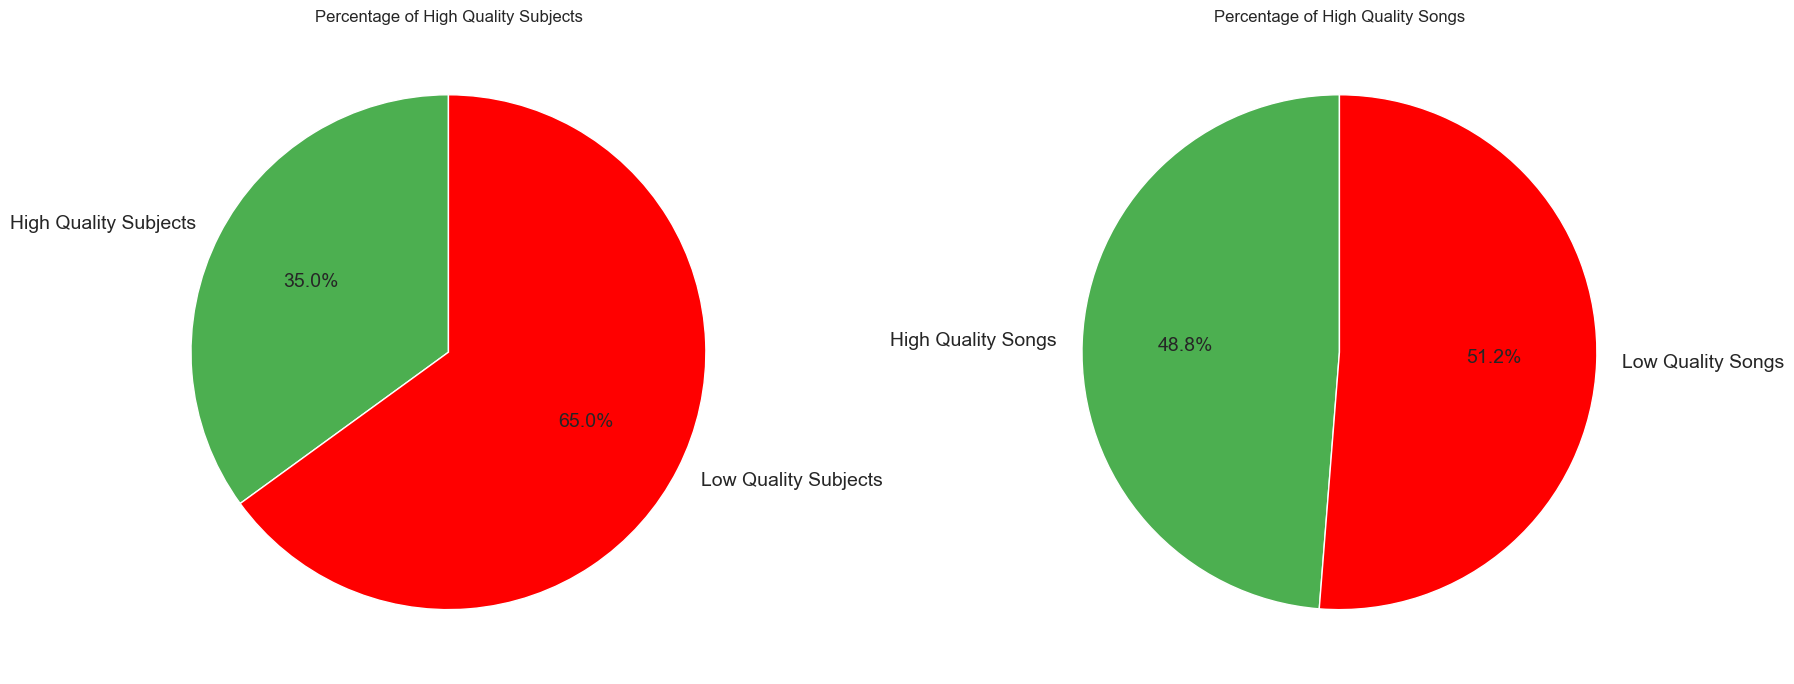

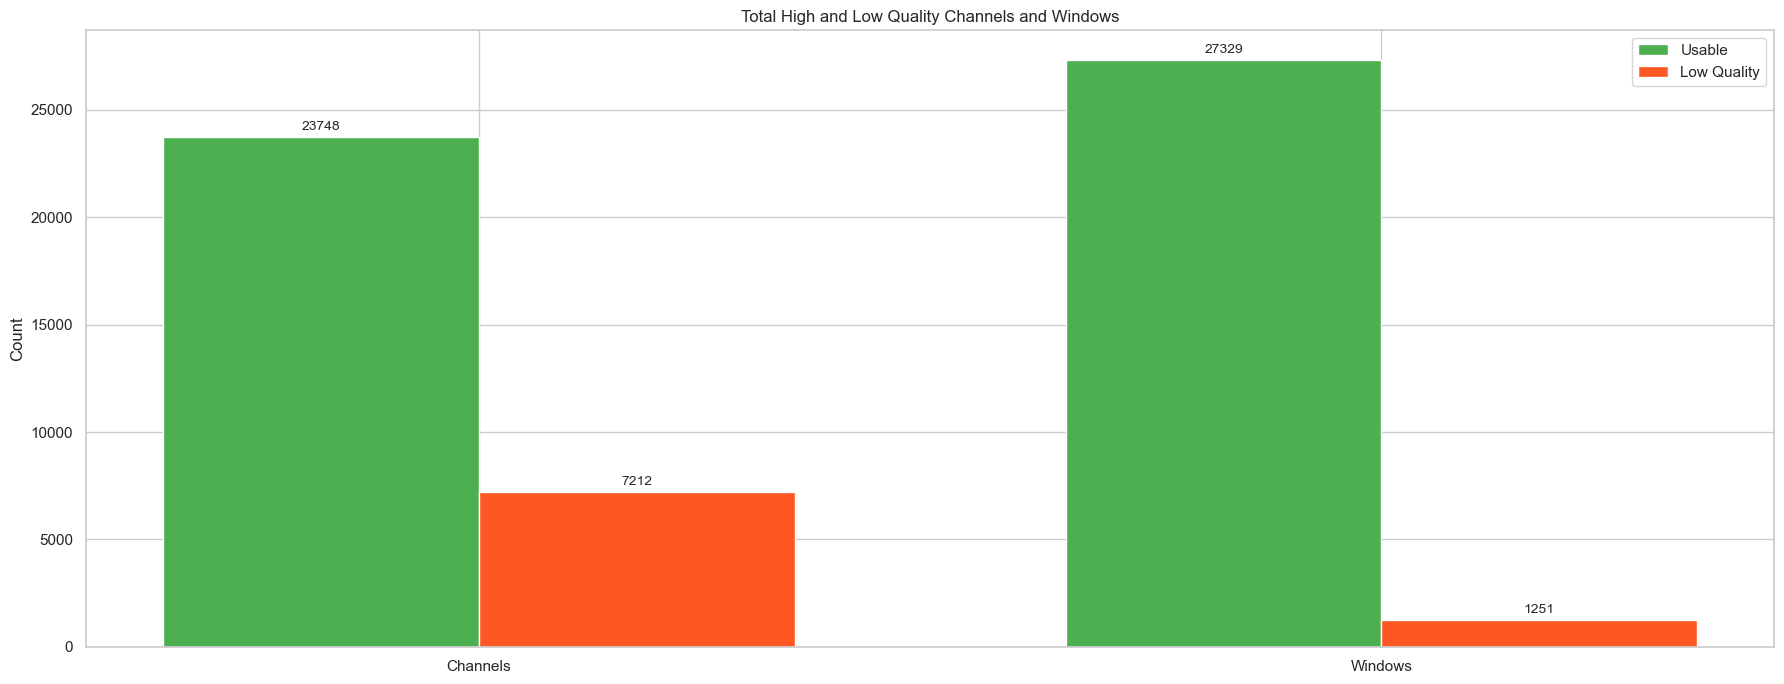

In [3]:
# Load data
data = scipy.io.loadmat('dsMUSING_quality_data.mat', squeeze_me=True, struct_as_record=False)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

quality_data = data['quality_data']
n_subjects = len(quality_data)
max_songs = 12

# Initialize variables
usable_songs_per_subject, percent_bad_channels_per_song, songs_per_subject = [], [], []
bad_channels_by_criterion = {k: [] for k in ['c1', 'c2', 'c3', 'c4']}
bad_windows_by_criterion = {k: [] for k in ['c3', 'c4']}
song_level_data = []

# Process data
for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    songs_per_subject.append(len(subj_songs))
    usable_count = 0

    for song in subj_songs:
        total_ch = song.total_channels
        bad_ch = {k: len(np.atleast_1d(getattr(song, f"{k}_bad_channels", []))) for k in bad_channels_by_criterion}
        for k, v in bad_ch.items(): bad_channels_by_criterion[k].append(v)

        for k in bad_windows_by_criterion:
            bad_windows_by_criterion[k].append(len(np.atleast_1d(getattr(song, f"{k}_bad_windows", []))))

        all_bad = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        percent_bad = 100 * len(all_bad) / total_ch
        percent_bad_channels_per_song.append(percent_bad)

        if percent_bad <= 20: usable_count += 1

        song_level_data.append({
            'subject': subj.subject_id,
            'song': song.song_id,
            'percent_bad': percent_bad,
            **bad_ch
        })

    usable_songs_per_subject.append(usable_count)

df_song = pd.DataFrame(song_level_data)

# ----- Heatmaps -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Heatmap over channels
heatmap_channels = np.full((n_subjects, max_songs), np.nan)
for r in df_song.itertuples():
    heatmap_channels[int(r.subject)-1, int(r.song)-1] = r.percent_bad

sns.heatmap(heatmap_channels, cmap='YlOrRd', ax=axes[0], cbar_kws={'label': '% Low Quality Channels'}, linewidths=0.5)
axes[0].set(title="Heatmap: % of Low Quality Channels", xlabel="Song", ylabel="Subject")
axes[0].set_xticks(np.arange(max_songs) + 0.5)
axes[0].set_yticks(np.arange(n_subjects) + 0.5)
axes[0].set_xticklabels(np.arange(1, max_songs + 1))
axes[0].set_yticklabels(np.arange(1, n_subjects + 1))

# Heatmap over windows
heatmap_windows = np.full((n_subjects, max_songs), np.nan)
for subj in quality_data:
    subj_id = int(subj.subject_id)
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    for song in subj_songs:
        song_id = int(song.song_id)
        total_windows = song.total_windows
        c3_bad = len(np.atleast_1d(getattr(song, 'c3_bad_windows', [])))
        c4_bad = len(np.atleast_1d(getattr(song, 'c4_bad_windows', [])))
        heatmap_windows[subj_id-1, song_id-1] = 100 * (c3_bad + c4_bad) / total_windows if total_windows else np.nan

sns.heatmap(heatmap_windows, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '% Low Quality Windows (C3 + C4)'}, linewidths=0.5)
axes[1].set(title="Heatmap: % of Low Quality Windows", xlabel="Song")
axes[1].set_xticks(np.arange(max_songs) + 0.5)
axes[1].set_yticks(np.arange(n_subjects) + 0.5)
axes[1].set_xticklabels(np.arange(1, max_songs + 1))
axes[1].set_yticklabels(np.arange(1, n_subjects + 1))

plt.tight_layout()
plt.savefig('dsDRYAD_heatmaps.png', dpi=200)
plt.show()

# ----- Pie Charts -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = ['#4CAF50', "#FF0000"]

# Subject and song quality
usable_subjects = sum(np.array(usable_songs_per_subject) > np.ceil(0.8 * max_songs))
subject_sizes = [100 * usable_subjects / n_subjects, 100 - 100 * usable_subjects / n_subjects]
song_sizes = [
    100 * sum(usable_songs_per_subject) / sum(songs_per_subject),
    100 - 100 * sum(usable_songs_per_subject) / sum(songs_per_subject)
]

axes[0].pie(subject_sizes, labels=['High Quality Subjects', 'Low Quality Subjects'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[0].set_title('Percentage of High Quality Subjects')

axes[1].pie(song_sizes, labels=['High Quality Songs', 'Low Quality Songs'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[1].set_title('Percentage of High Quality Songs')

plt.tight_layout()
plt.savefig('dsDRYAD_pie.png', dpi=200)
plt.show()

# ----- Bar Charts -----
usable_channels_all = usable_windows_all = total_channels_all = total_windows_all = 0

for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, (list, np.ndarray)) else [subj.songs]
    for song in subj_songs:
        # Channels
        total_channels = song.total_channels
        bad_channels = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        total_channels_all += total_channels
        usable_channels_all += total_channels - len(bad_channels)

        # Windows
        total_windows = song.total_windows
        bad_windows = sum(len(np.atleast_1d(getattr(song, f"c{i}_bad_windows", []))) for i in [3, 4])
        total_windows_all += total_windows
        usable_windows_all += total_windows - bad_windows

# Bar
labels = ['Channels', 'Windows']
usable = [usable_channels_all, usable_windows_all]
non_usable = [total_channels_all - usable_channels_all, total_windows_all - usable_windows_all]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 7))
bars1 = ax.bar(x - width/2, usable, width, label='Usable', color='#4CAF50')
bars2 = ax.bar(x + width/2, non_usable, width, label='Low Quality', color='#FF5722')

ax.set_ylabel('Count')
ax.set_title('Total High and Low Quality Channels and Windows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('dsDRYAD_bar.png', dpi=200)
plt.show()


## dsNMEDE

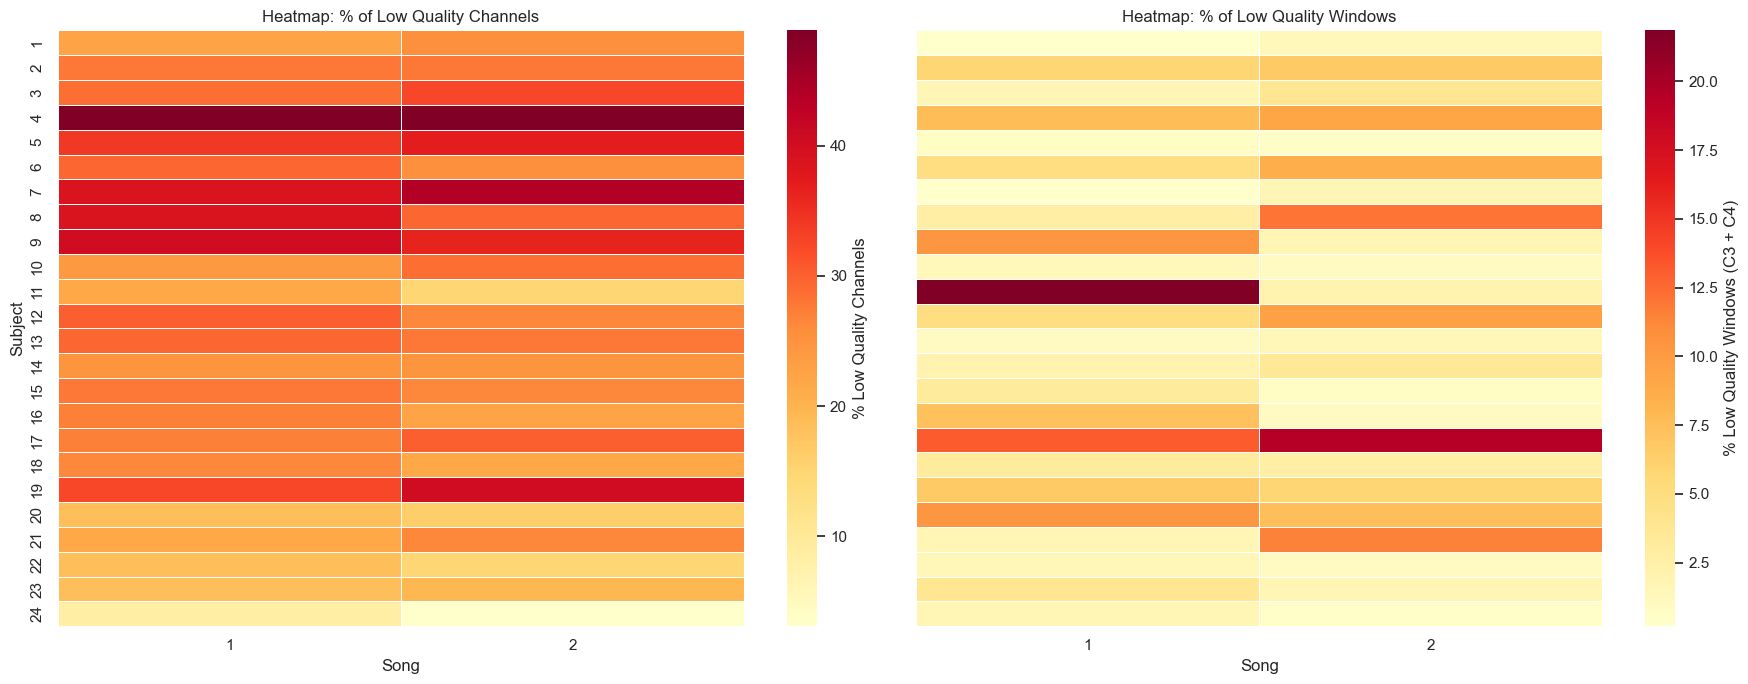

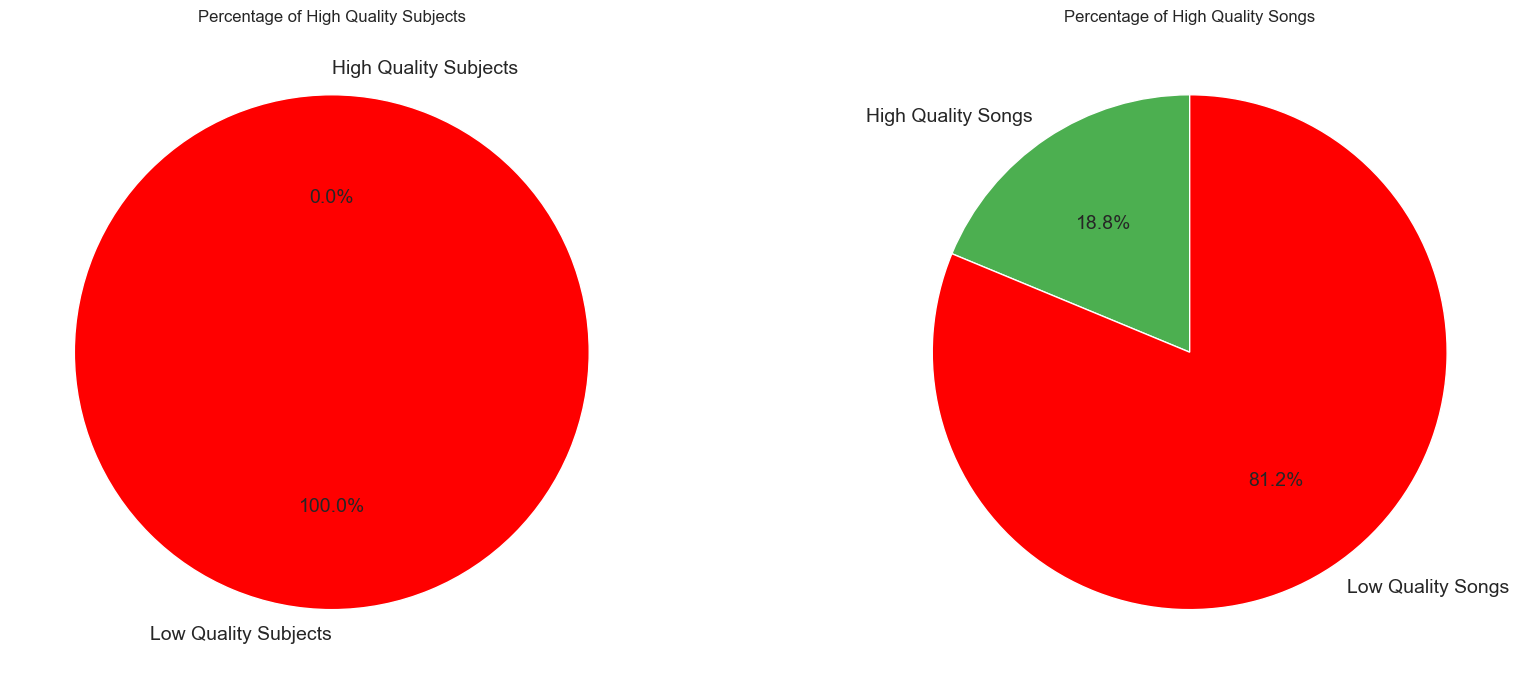

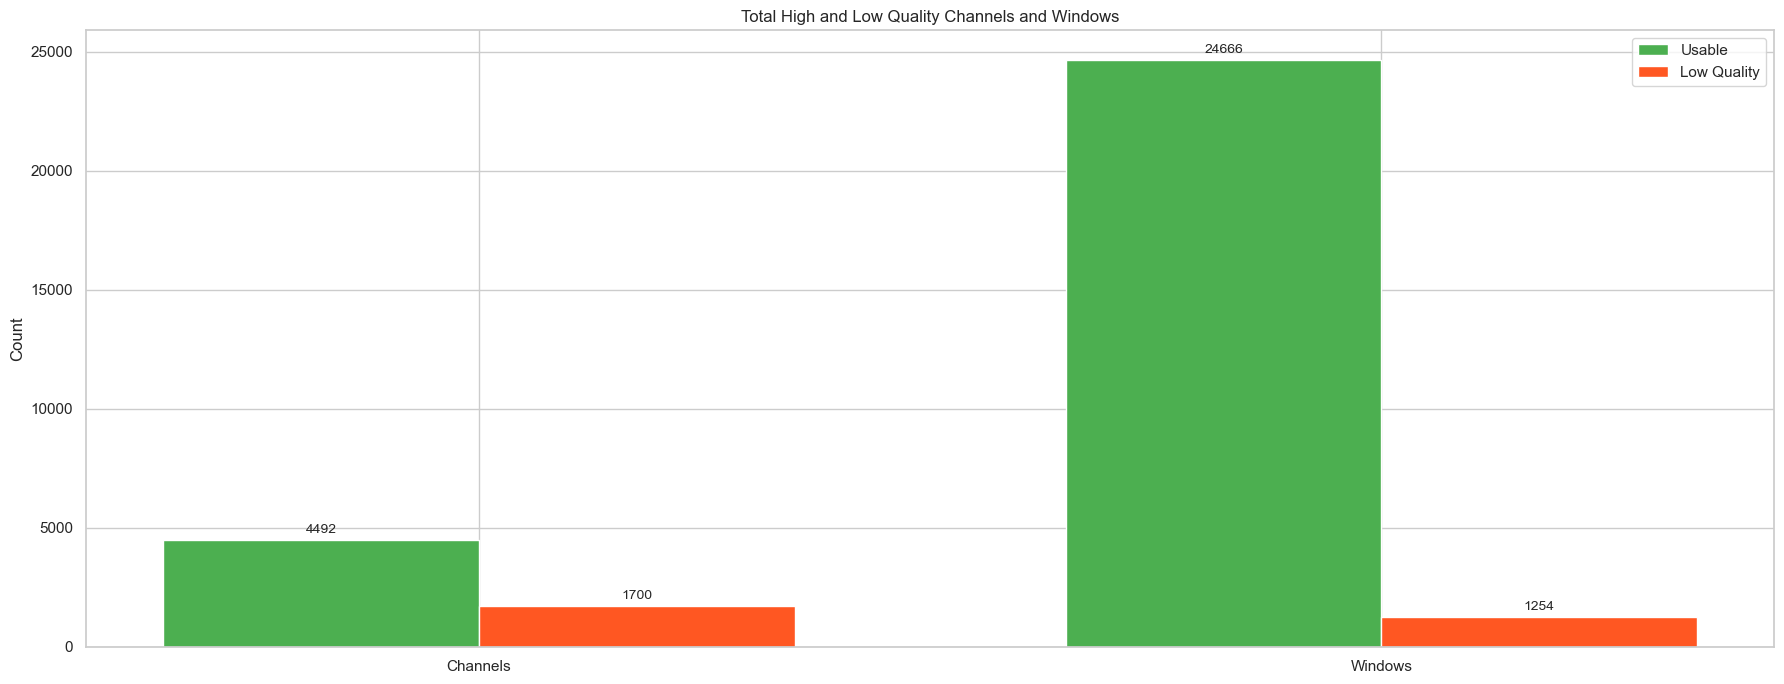

In [4]:
# Load data
data = scipy.io.loadmat('dsNMEDE_quality_data.mat', squeeze_me=True, struct_as_record=False)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

quality_data = data['quality_data']
n_subjects = len(quality_data)
max_songs = 2

# Initialize variables
usable_songs_per_subject, percent_bad_channels_per_song, songs_per_subject = [], [], []
bad_channels_by_criterion = {k: [] for k in ['c1', 'c2', 'c3', 'c4']}
bad_windows_by_criterion = {k: [] for k in ['c3', 'c4']}
song_level_data = []

# Process data
for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    songs_per_subject.append(len(subj_songs))
    usable_count = 0

    for song in subj_songs:
        total_ch = song.total_channels
        bad_ch = {k: len(np.atleast_1d(getattr(song, f"{k}_bad_channels", []))) for k in bad_channels_by_criterion}
        for k, v in bad_ch.items(): bad_channels_by_criterion[k].append(v)

        for k in bad_windows_by_criterion:
            bad_windows_by_criterion[k].append(len(np.atleast_1d(getattr(song, f"{k}_bad_windows", []))))

        all_bad = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        percent_bad = 100 * len(all_bad) / total_ch
        percent_bad_channels_per_song.append(percent_bad)

        if percent_bad <= 20: usable_count += 1

        song_level_data.append({
            'subject': subj.subject_id,
            'song': song.song_id,
            'percent_bad': percent_bad,
            **bad_ch
        })

    usable_songs_per_subject.append(usable_count)

df_song = pd.DataFrame(song_level_data)

# ----- Heatmaps -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Heatmap over channels
heatmap_channels = np.full((n_subjects, max_songs), np.nan)
for r in df_song.itertuples():
    heatmap_channels[int(r.subject)-1, int(r.song)-1] = r.percent_bad

sns.heatmap(heatmap_channels, cmap='YlOrRd', ax=axes[0], cbar_kws={'label': '% Low Quality Channels'}, linewidths=0.5)
axes[0].set(title="Heatmap: % of Low Quality Channels", xlabel="Song", ylabel="Subject")
axes[0].set_xticks(np.arange(max_songs) + 0.5)
axes[0].set_yticks(np.arange(n_subjects) + 0.5)
axes[0].set_xticklabels(np.arange(1, max_songs + 1))
axes[0].set_yticklabels(np.arange(1, n_subjects + 1))

# Heatmap over windows
heatmap_windows = np.full((n_subjects, max_songs), np.nan)
for subj in quality_data:
    subj_id = int(subj.subject_id)
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    for song in subj_songs:
        song_id = int(song.song_id)
        total_windows = song.total_windows
        c3_bad = len(np.atleast_1d(getattr(song, 'c3_bad_windows', [])))
        c4_bad = len(np.atleast_1d(getattr(song, 'c4_bad_windows', [])))
        heatmap_windows[subj_id-1, song_id-1] = 100 * (c3_bad + c4_bad) / total_windows if total_windows else np.nan

sns.heatmap(heatmap_windows, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '% Low Quality Windows (C3 + C4)'}, linewidths=0.5)
axes[1].set(title="Heatmap: % of Low Quality Windows", xlabel="Song")
axes[1].set_xticks(np.arange(max_songs) + 0.5)
axes[1].set_yticks(np.arange(n_subjects) + 0.5)
axes[1].set_xticklabels(np.arange(1, max_songs + 1))
axes[1].set_yticklabels(np.arange(1, n_subjects + 1))

plt.tight_layout()
plt.savefig('dsDRYAD_heatmaps.png', dpi=200)
plt.show()

# ----- Pie Charts -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = ['#4CAF50', "#FF0000"]

# Subject and song quality
usable_subjects = sum(np.array(usable_songs_per_subject) > np.ceil(0.8 * max_songs))
subject_sizes = [100 * usable_subjects / n_subjects, 100 - 100 * usable_subjects / n_subjects]
song_sizes = [
    100 * sum(usable_songs_per_subject) / sum(songs_per_subject),
    100 - 100 * sum(usable_songs_per_subject) / sum(songs_per_subject)
]

axes[0].pie(subject_sizes, labels=['High Quality Subjects', 'Low Quality Subjects'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[0].set_title('Percentage of High Quality Subjects')

axes[1].pie(song_sizes, labels=['High Quality Songs', 'Low Quality Songs'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[1].set_title('Percentage of High Quality Songs')

plt.tight_layout()
plt.savefig('dsDRYAD_pie.png', dpi=200)
plt.show()

# ----- Bar Charts -----
usable_channels_all = usable_windows_all = total_channels_all = total_windows_all = 0

for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, (list, np.ndarray)) else [subj.songs]
    for song in subj_songs:
        # Channels
        total_channels = song.total_channels
        bad_channels = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        total_channels_all += total_channels
        usable_channels_all += total_channels - len(bad_channels)

        # Windows
        total_windows = song.total_windows
        bad_windows = sum(len(np.atleast_1d(getattr(song, f"c{i}_bad_windows", []))) for i in [3, 4])
        total_windows_all += total_windows
        usable_windows_all += total_windows - bad_windows

# Bar
labels = ['Channels', 'Windows']
usable = [usable_channels_all, usable_windows_all]
non_usable = [total_channels_all - usable_channels_all, total_windows_all - usable_windows_all]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 7))
bars1 = ax.bar(x - width/2, usable, width, label='Usable', color='#4CAF50')
bars2 = ax.bar(x + width/2, non_usable, width, label='Low Quality', color='#FF5722')

ax.set_ylabel('Count')
ax.set_title('Total High and Low Quality Channels and Windows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('dsDRYAD_bar.png', dpi=200)
plt.show()


## dsAUTh

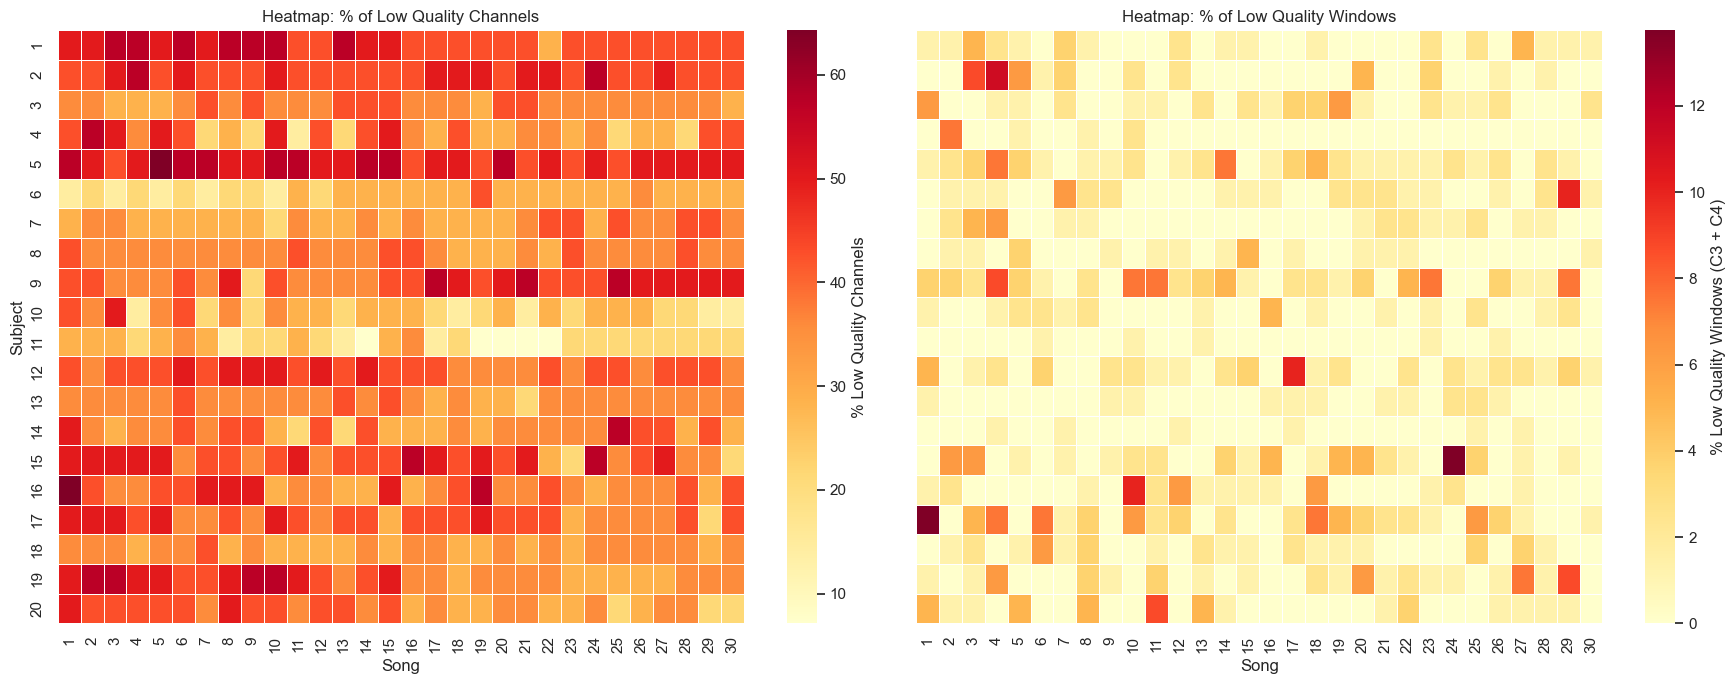

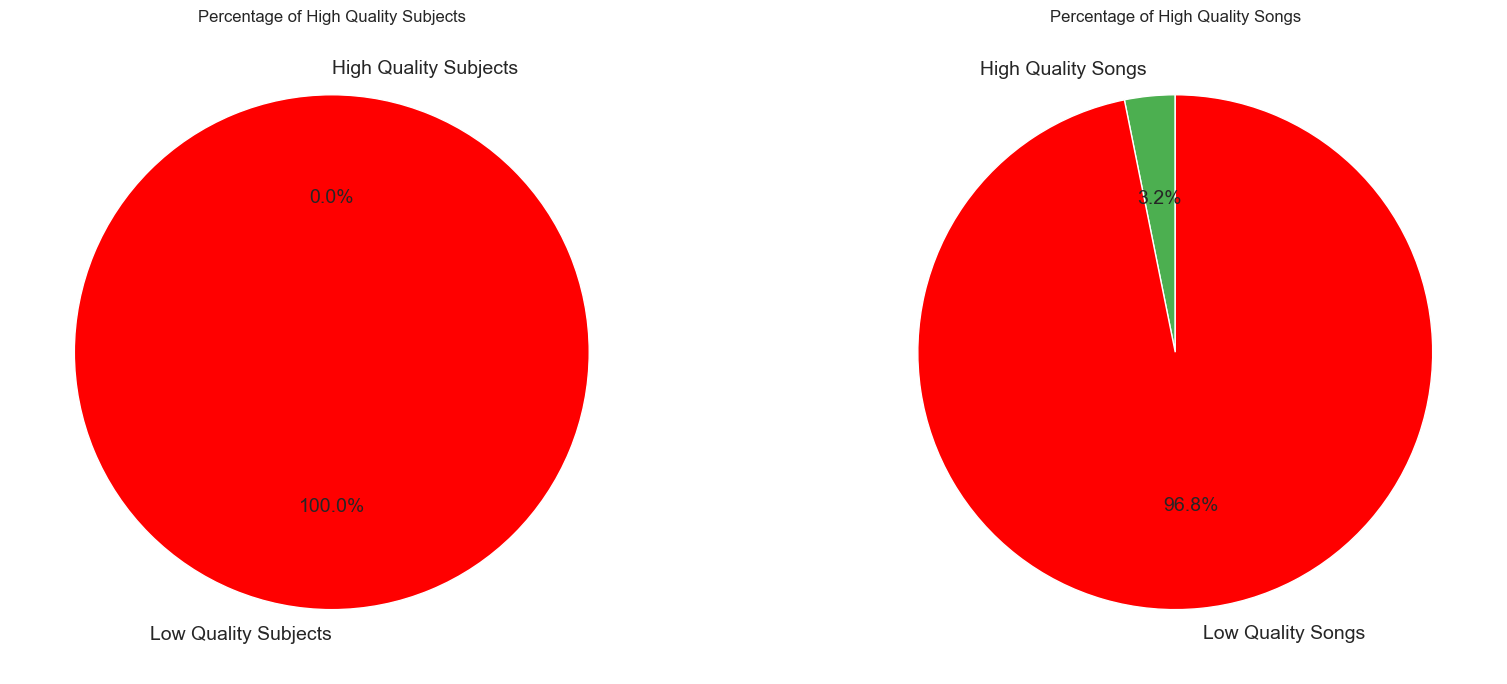

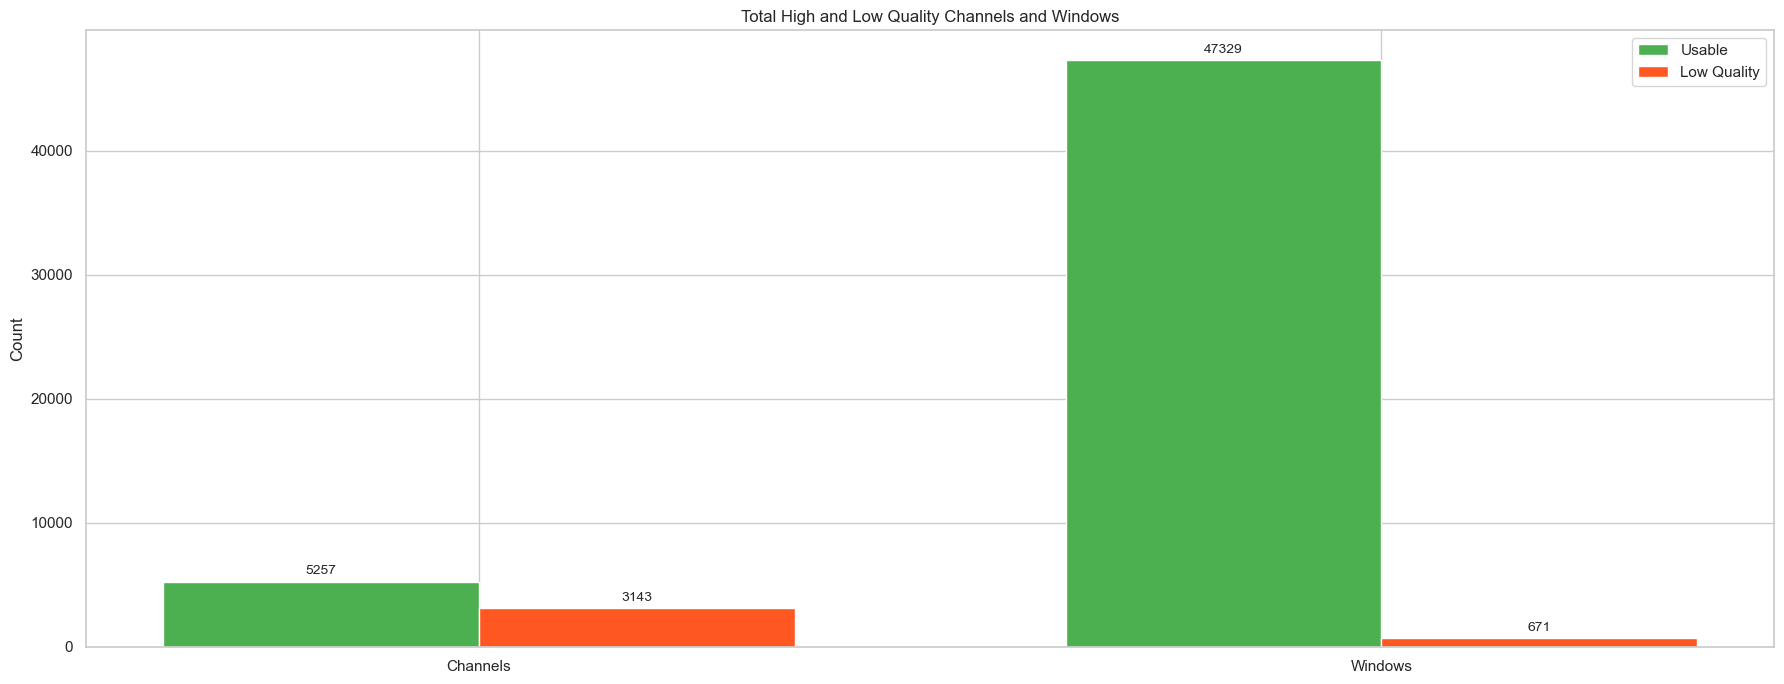

In [5]:
# Load data
data = scipy.io.loadmat('dsAUTh_quality_data.mat', squeeze_me=True, struct_as_record=False)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

quality_data = data['quality_data']
n_subjects = len(quality_data)
max_songs = 30

# Initialize variables
usable_songs_per_subject, percent_bad_channels_per_song, songs_per_subject = [], [], []
bad_channels_by_criterion = {k: [] for k in ['c1', 'c2', 'c3', 'c4']}
bad_windows_by_criterion = {k: [] for k in ['c3', 'c4']}
song_level_data = []

# Process data
for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    songs_per_subject.append(len(subj_songs))
    usable_count = 0

    for song in subj_songs:
        total_ch = song.total_channels
        bad_ch = {k: len(np.atleast_1d(getattr(song, f"{k}_bad_channels", []))) for k in bad_channels_by_criterion}
        for k, v in bad_ch.items(): bad_channels_by_criterion[k].append(v)

        for k in bad_windows_by_criterion:
            bad_windows_by_criterion[k].append(len(np.atleast_1d(getattr(song, f"{k}_bad_windows", []))))

        all_bad = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        percent_bad = 100 * len(all_bad) / total_ch
        percent_bad_channels_per_song.append(percent_bad)

        if percent_bad <= 20: usable_count += 1

        song_level_data.append({
            'subject': subj.subject_id,
            'song': song.song_id,
            'percent_bad': percent_bad,
            **bad_ch
        })

    usable_songs_per_subject.append(usable_count)

df_song = pd.DataFrame(song_level_data)

# ----- Heatmaps -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)

# Heatmap over channels
heatmap_channels = np.full((n_subjects, max_songs), np.nan)
for r in df_song.itertuples():
    heatmap_channels[int(r.subject)-1, int(r.song)-1] = r.percent_bad

sns.heatmap(heatmap_channels, cmap='YlOrRd', ax=axes[0], cbar_kws={'label': '% Low Quality Channels'}, linewidths=0.5)
axes[0].set(title="Heatmap: % of Low Quality Channels", xlabel="Song", ylabel="Subject")
axes[0].set_xticks(np.arange(max_songs) + 0.5)
axes[0].set_yticks(np.arange(n_subjects) + 0.5)
axes[0].set_xticklabels(np.arange(1, max_songs + 1))
axes[0].set_yticklabels(np.arange(1, n_subjects + 1))

# Heatmap over windows
heatmap_windows = np.full((n_subjects, max_songs), np.nan)
for subj in quality_data:
    subj_id = int(subj.subject_id)
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    for song in subj_songs:
        song_id = int(song.song_id)
        total_windows = song.total_windows
        c3_bad = len(np.atleast_1d(getattr(song, 'c3_bad_windows', [])))
        c4_bad = len(np.atleast_1d(getattr(song, 'c4_bad_windows', [])))
        heatmap_windows[subj_id-1, song_id-1] = 100 * (c3_bad + c4_bad) / total_windows if total_windows else np.nan

sns.heatmap(heatmap_windows, cmap='YlOrRd', ax=axes[1], cbar_kws={'label': '% Low Quality Windows (C3 + C4)'}, linewidths=0.5)
axes[1].set(title="Heatmap: % of Low Quality Windows", xlabel="Song")
axes[1].set_xticks(np.arange(max_songs) + 0.5)
axes[1].set_yticks(np.arange(n_subjects) + 0.5)
axes[1].set_xticklabels(np.arange(1, max_songs + 1))
axes[1].set_yticklabels(np.arange(1, n_subjects + 1))

plt.tight_layout()
plt.savefig('dsDRYAD_heatmaps.png', dpi=200)
plt.show()

# ----- Pie Charts -----
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
colors = ['#4CAF50', "#FF0000"]

# Subject and song quality
usable_subjects = sum(np.array(usable_songs_per_subject) > np.ceil(0.8 * max_songs))
subject_sizes = [100 * usable_subjects / n_subjects, 100 - 100 * usable_subjects / n_subjects]
song_sizes = [
    100 * sum(usable_songs_per_subject) / sum(songs_per_subject),
    100 - 100 * sum(usable_songs_per_subject) / sum(songs_per_subject)
]

axes[0].pie(subject_sizes, labels=['High Quality Subjects', 'Low Quality Subjects'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[0].set_title('Percentage of High Quality Subjects')

axes[1].pie(song_sizes, labels=['High Quality Songs', 'Low Quality Songs'],
            autopct='%1.1f%%', startangle=90, colors=colors, textprops={'fontsize': 14})
axes[1].set_title('Percentage of High Quality Songs')

plt.tight_layout()
plt.savefig('dsDRYAD_pie.png', dpi=200)
plt.show()

# ----- Bar Charts -----
usable_channels_all = usable_windows_all = total_channels_all = total_windows_all = 0

for subj in quality_data:
    subj_songs = subj.songs if isinstance(subj.songs, (list, np.ndarray)) else [subj.songs]
    for song in subj_songs:
        # Channels
        total_channels = song.total_channels
        bad_channels = set(sum([list(np.atleast_1d(getattr(song, f"c{i}_bad_channels", []))) for i in range(1, 5)], []))
        total_channels_all += total_channels
        usable_channels_all += total_channels - len(bad_channels)

        # Windows
        total_windows = song.total_windows
        bad_windows = sum(len(np.atleast_1d(getattr(song, f"c{i}_bad_windows", []))) for i in [3, 4])
        total_windows_all += total_windows
        usable_windows_all += total_windows - bad_windows

# Bar
labels = ['Channels', 'Windows']
usable = [usable_channels_all, usable_windows_all]
non_usable = [total_channels_all - usable_channels_all, total_windows_all - usable_windows_all]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 7))
bars1 = ax.bar(x - width/2, usable, width, label='Usable', color='#4CAF50')
bars2 = ax.bar(x + width/2, non_usable, width, label='Low Quality', color='#FF5722')

ax.set_ylabel('Count')
ax.set_title('Total High and Low Quality Channels and Windows')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

for bar in bars1 + bars2:
    ax.annotate(f'{int(bar.get_height())}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('dsDRYAD_bar.png', dpi=200)
plt.show()


## dsRIUMA

C:\Users\alr00\AppData\Local\Temp\ipykernel_4164\340538971.py:95: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if subj.subject_id not in unique_subject_ids:


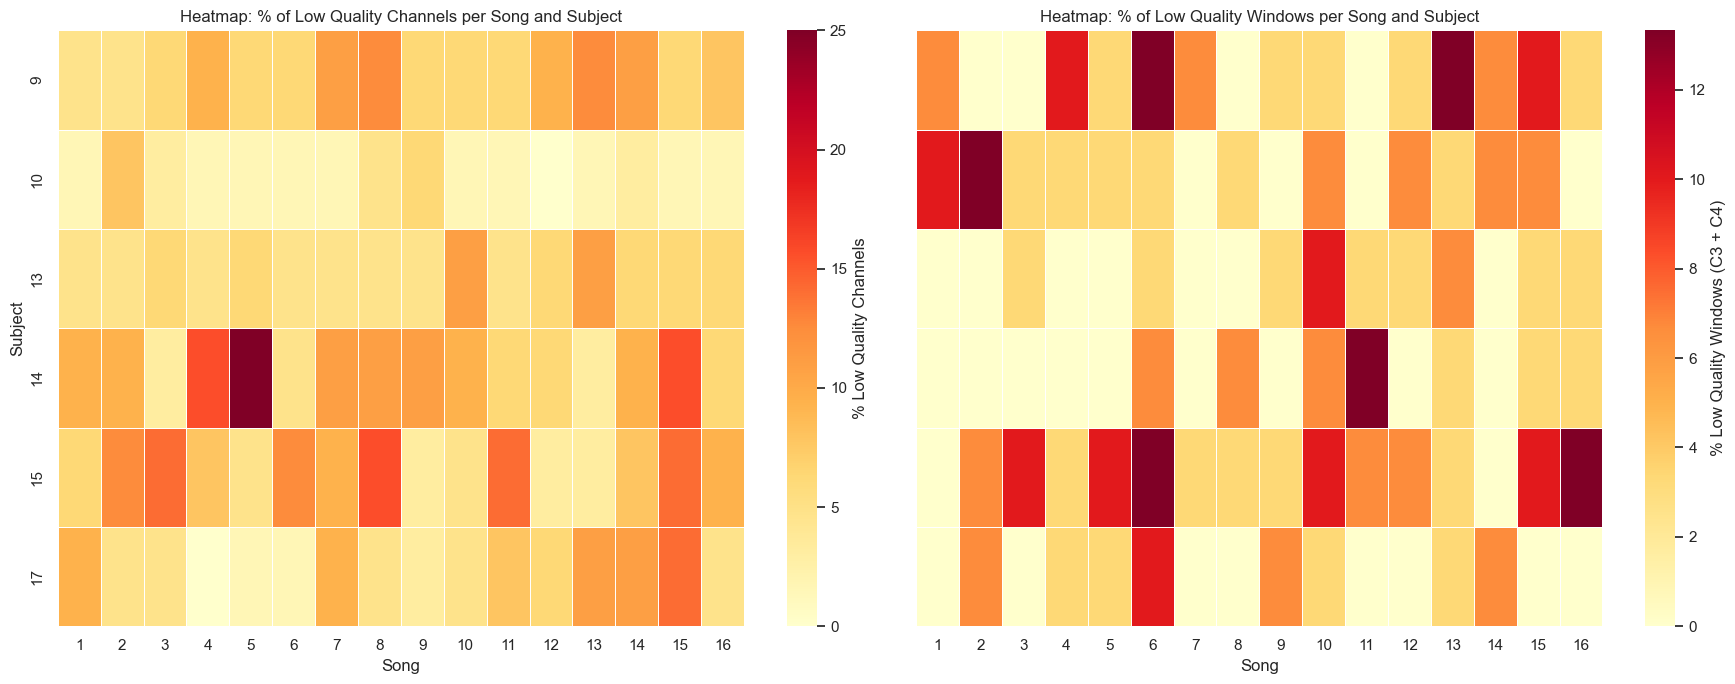

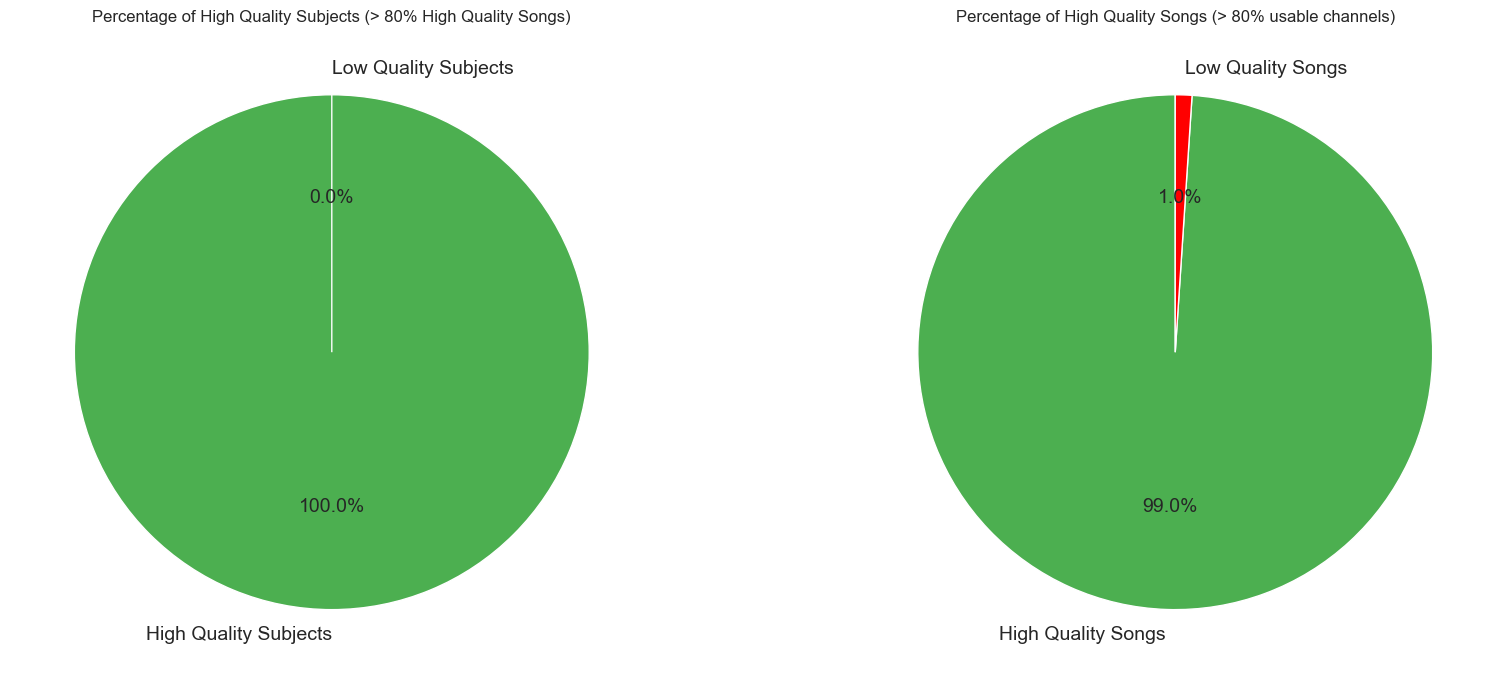

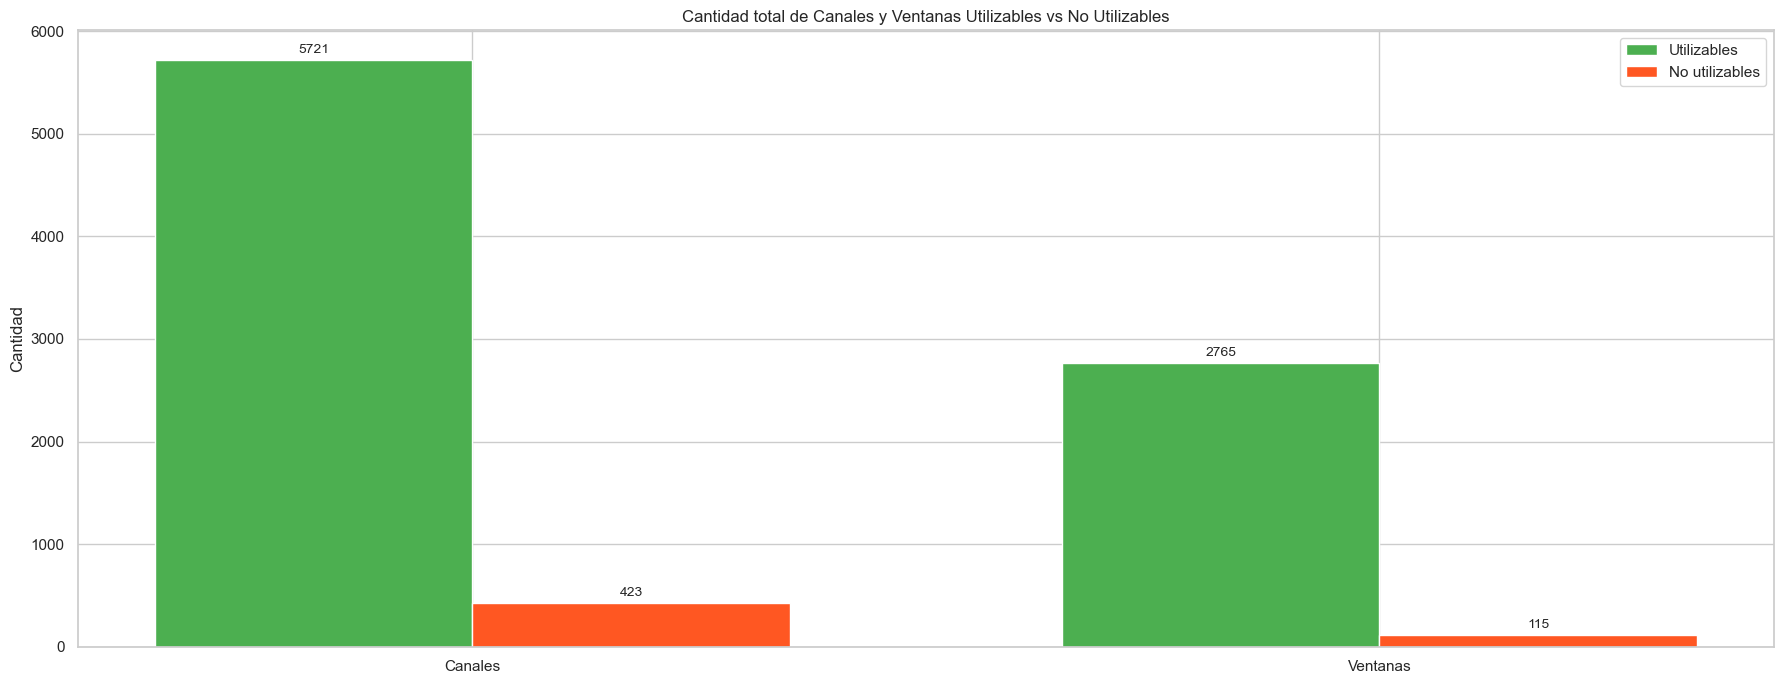

In [11]:
data = scipy.io.loadmat('dsRIUMA_quality_data.mat', squeeze_me=True, struct_as_record=False)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Load data
quality_data = data['quality_data']
n_subjects = len(quality_data)
max_songs = 16

# Initialize variables
usable_songs_per_subject = []
percent_bad_channels_per_song = []
bad_channels_by_criterion = {'c1': [], 'c2': [], 'c3': [], 'c4': []}
bad_windows_by_criterion = {'c3': [], 'c4': []}
songs_per_subject = []
song_level_data = []

# Process data
for subj in quality_data:
    subj_usable_songs = 0
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    songs_per_subject.append(len(subj_songs))

    for song in subj_songs:
        total_ch = song.total_channels

        bad_ch = {}
        for key in bad_channels_by_criterion:
            ch_list = getattr(song, f"{key}_bad_channels", [])
            ch_count = len(np.atleast_1d(ch_list))
            bad_channels_by_criterion[key].append(ch_count)
            bad_ch[key] = ch_count

        for key in bad_windows_by_criterion:
            win_list = getattr(song, f"{key}_bad_windows", [])
            bad_windows_by_criterion[key].append(len(np.atleast_1d(win_list)))

        total_bad = len(set(
            list(np.atleast_1d(song.c1_bad_channels)) +
            list(np.atleast_1d(song.c2_bad_channels)) +
            list(np.atleast_1d(song.c3_bad_channels)) +
            list(np.atleast_1d(song.c4_bad_channels))
        ))
        percent_bad = 100 * total_bad / total_ch
        percent_bad_channels_per_song.append(percent_bad)

        if percent_bad <= 20:
            subj_usable_songs += 1

        song_level_data.append({
            'subject': subj.subject_id,
            'song': song.song_id,
            'percent_bad': percent_bad,
            **bad_ch
        })

    usable_songs_per_subject.append(subj_usable_songs)

df_song = pd.DataFrame(song_level_data)

# Get unique subject IDs and number of subjects
unique_subject_ids = sorted(df_song['subject'].unique())
n_subjects = len(unique_subject_ids)

# Create a mapping from subject IDs to indices
subject_id_to_index = {sid: idx for idx, sid in enumerate(unique_subject_ids)}


# ----- Heatmap 1: % Low Quality Channels -----
heatmap_matrix_channels = np.full((n_subjects, max_songs), np.nan)
for row in df_song.itertuples():
    row_idx = subject_id_to_index[int(row.subject)]
    heatmap_matrix_channels[row_idx, int(row.song) - 1] = row.percent_bad

# Plot heatmap 1
fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
sns.heatmap(
    heatmap_matrix_channels,
    cmap='YlOrRd',
    ax=axes[0],
    cbar_kws={'label': '% Low Quality Channels'},
    linewidths=0.5
)
axes[0].set_title("Heatmap: % of Low Quality Channels per Song and Subject")
axes[0].set_xlabel("Song")
axes[0].set_ylabel("Subject")
axes[0].set_xticks(np.arange(max_songs) + 0.5)
axes[0].set_yticks(np.arange(n_subjects) + 0.5)
axes[0].set_xticklabels(np.arange(1, max_songs + 1))
axes[0].set_yticklabels(unique_subject_ids)

# ----- Heatmap 2: % Low Quality Windows (C3 + C4) -----
heatmap_matrix_windows = np.full((n_subjects, max_songs), np.nan)
for subj in quality_data:
    if subj.subject_id not in unique_subject_ids:
        continue
    subj_id = int(subj.subject_id)
    row_idx = subject_id_to_index[subj_id]
    subj_songs = subj.songs if isinstance(subj.songs, np.ndarray) else [subj.songs]
    for song in subj_songs:
        song_id = int(song.song_id)
        total_windows = song.total_windows
        c3_bad = len(np.atleast_1d(getattr(song, 'c3_bad_windows', [])))
        c4_bad = len(np.atleast_1d(getattr(song, 'c4_bad_windows', [])))
        total_bad = c3_bad + c4_bad
        percent_bad = 100 * total_bad / total_windows if total_windows > 0 else np.nan
        heatmap_matrix_windows[row_idx, song_id - 1] = percent_bad

# Plot heatmap 2
sns.heatmap(
    heatmap_matrix_windows,
    cmap='YlOrRd',
    ax=axes[1],
    cbar_kws={'label': '% Low Quality Windows (C3 + C4)'},
    linewidths=0.5
)
axes[1].set_title("Heatmap: % of Low Quality Windows per Song and Subject")
axes[1].set_xlabel("Song")
axes[1].set_ylabel("") 
axes[1].set_xticks(np.arange(max_songs) + 0.5)
axes[1].set_yticks(np.arange(n_subjects) + 0.5)
axes[1].set_xticklabels(np.arange(1, max_songs + 1))
axes[1].set_yticklabels(unique_subject_ids)

plt.tight_layout()
plt.savefig('dsRIUMA_heatmaps.png', dpi=200)
plt.show()

# Pie charts side by side with same figsize
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Calculate percentages
usable_subjects = sum(np.array(usable_songs_per_subject) > np.ceil(0.8 * max_songs))
percent_usable_subjects = 100 * usable_subjects / n_subjects
percent_non_usable_subjects = 100 - percent_usable_subjects

total_songs = sum(songs_per_subject)
total_usable_songs = sum(usable_songs_per_subject)
percent_usable_songs = 100 * total_usable_songs / total_songs
percent_non_usable_songs = 100 - percent_usable_songs

# Data for pie charts
subject_sizes = [percent_usable_subjects, percent_non_usable_subjects]
subject_labels = ['High Quality Subjects', 'Low Quality Subjects']
song_sizes = [percent_usable_songs, percent_non_usable_songs]
song_labels = ['High Quality Songs', 'Low Quality Songs']

colors = ['#4CAF50', "#FF0000"]

# Pie chart High Quality Subjects
axes[0].pie(subject_sizes, labels=subject_labels, autopct='%1.1f%%', startangle=90,
            colors=colors, textprops={'fontsize': 14})
axes[0].set_title('Percentage of High Quality Subjects (> 80% High Quality Songs)')

# Pie chart High Quality Songs
axes[1].pie(song_sizes, labels=song_labels, autopct='%1.1f%%', startangle=90,
            colors=colors, textprops={'fontsize': 14})
axes[1].set_title('Percentage of High Quality Songs (> 80% usable channels)')

plt.tight_layout()
plt.savefig('dsRIUMA_pie.png', dpi=200)
plt.show()

# Initialize variables for bar chart
total_channels_all = 0
usable_channels_all = 0
total_windows_all = 0
usable_windows_all = 0

# Iterate through subjects and songs to calculate totals
for subj in quality_data:
    subj_id_raw = subj.subject_id
    if isinstance(subj_id_raw, (np.ndarray, list)):
        if len(subj_id_raw) == 0:
            continue
        subj_id = int(subj_id_raw[0])
    else:
        if subj_id_raw is None or (isinstance(subj_id_raw, float) and np.isnan(subj_id_raw)):
            continue
        subj_id = int(subj_id_raw)

    # Verify if subject ID is in the mapping
    if subj_id not in subject_id_to_index:
        continue

    subj_songs = subj.songs if isinstance(subj.songs, (list, np.ndarray)) else [subj.songs]

    for song in subj_songs:
        # ---- Channels ----
        total_channels = song.total_channels
        bad_c1 = len(np.atleast_1d(getattr(song, 'c1_bad_channels', [])))
        bad_c2 = len(np.atleast_1d(getattr(song, 'c2_bad_channels', [])))
        bad_c3 = len(np.atleast_1d(getattr(song, 'c3_bad_channels', [])))
        bad_c4 = len(np.atleast_1d(getattr(song, 'c4_bad_channels', [])))

        total_bad_channels = len(set(
            list(np.atleast_1d(song.c1_bad_channels)) +
            list(np.atleast_1d(song.c2_bad_channels)) +
            list(np.atleast_1d(song.c3_bad_channels)) +
            list(np.atleast_1d(song.c4_bad_channels))
        ))

        total_channels_all += total_channels
        usable_channels_all += total_channels - total_bad_channels

        # ---- Windows ----
        total_windows = song.total_windows
        bad_windows_c3 = len(np.atleast_1d(getattr(song, 'c3_bad_windows', [])))
        bad_windows_c4 = len(np.atleast_1d(getattr(song, 'c4_bad_windows', [])))

        total_bad_windows = bad_windows_c3 + bad_windows_c4
        total_windows_all += total_windows
        usable_windows_all += total_windows - total_bad_windows

non_usable_channels = total_channels_all - usable_channels_all
non_usable_windows = total_windows_all - usable_windows_all

# Data for bar chart
labels = ['Canales', 'Ventanas']
usable = [usable_channels_all, usable_windows_all]
non_usable = [non_usable_channels, non_usable_windows]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(18, 7))
bars1 = ax.bar(x - width/2, usable, width, label='Utilizables', color='#4CAF50')
bars2 = ax.bar(x + width/2, non_usable, width, label='No utilizables', color='#FF5722')

# Labels and title
ax.set_ylabel('Cantidad')
ax.set_title('Cantidad total de Canales y Ventanas Utilizables vs No Utilizables')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('dsRIUMA_bar.png', dpi=200)
plt.show()
